## Taxi order forecasting

The taxi company accumulated historical data about number of taxi orders at airports. They want to get a forecast about number of orders for every next hour with a purpose to attract more cars in time of maximal load. We have to build ML model for such predictions.
The level of RMSE on test data must be less than 48.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from datetime import timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score, train_test_split,GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor


import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category = Warning)

In [3]:
df_taxi=pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [4]:
df_taxi=df_taxi.sort_index(axis=0)
print(df_taxi.index.is_monotonic)

True


In [5]:
df_taxi=df_taxi.resample('1H').sum()

# Time series analysis

In [6]:
decomposed = seasonal_decompose(df_taxi)

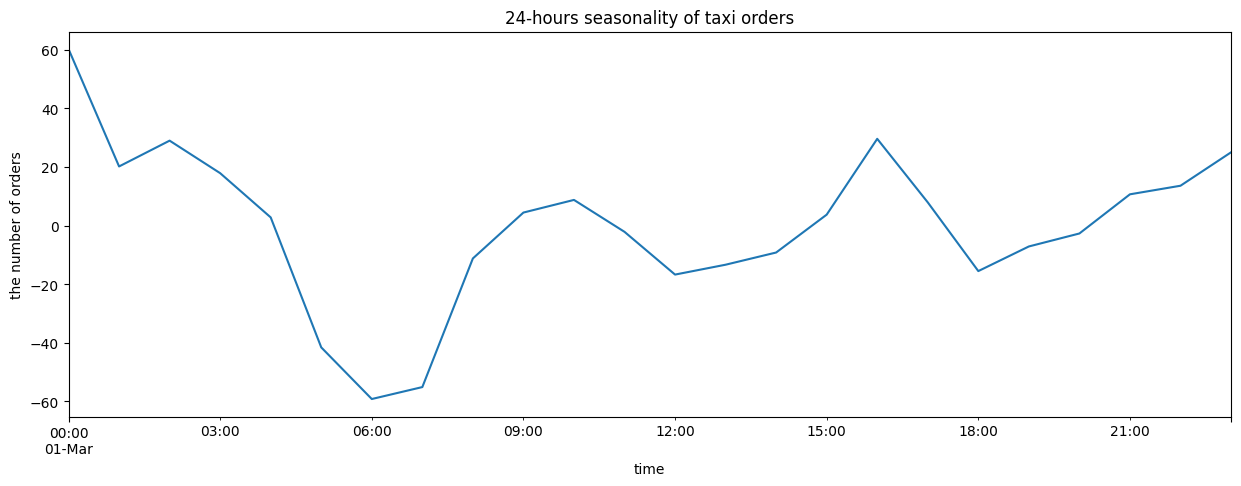

In [9]:
decomposed.seasonal['2018-03-01':'2018-03-01'].plot(title='24-hours seasonality of taxi orders',
                                                    ylabel= 'the number of orders', xlabel= 'time', figsize=(15,5));

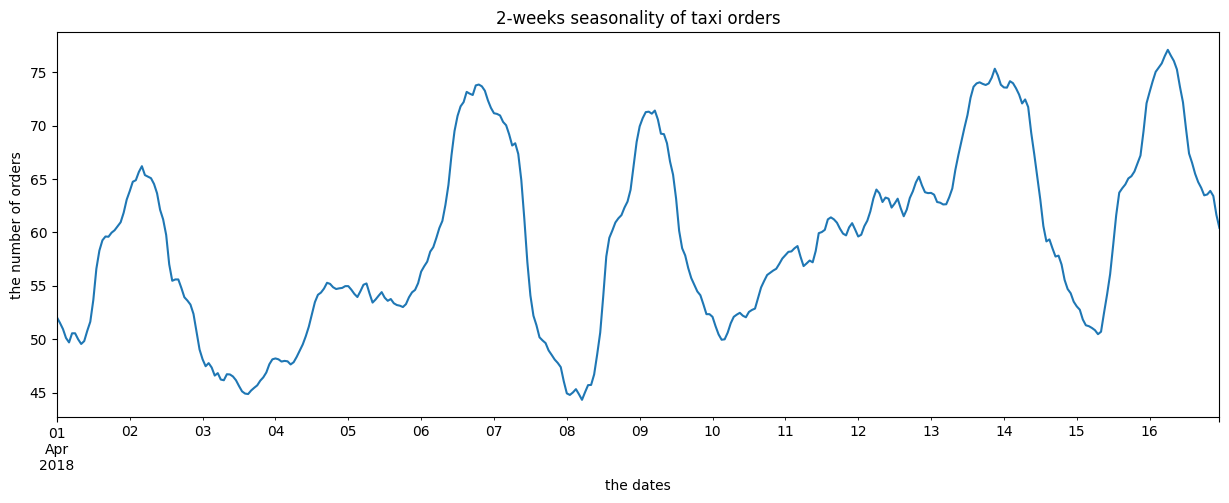

In [10]:
decomposed.trend['2018-04-01':'2018-04-16'].plot(title='2-weeks seasonality of taxi orders',
                                                 ylabel= 'the number of orders', xlabel= 'the dates', figsize=(15,5));

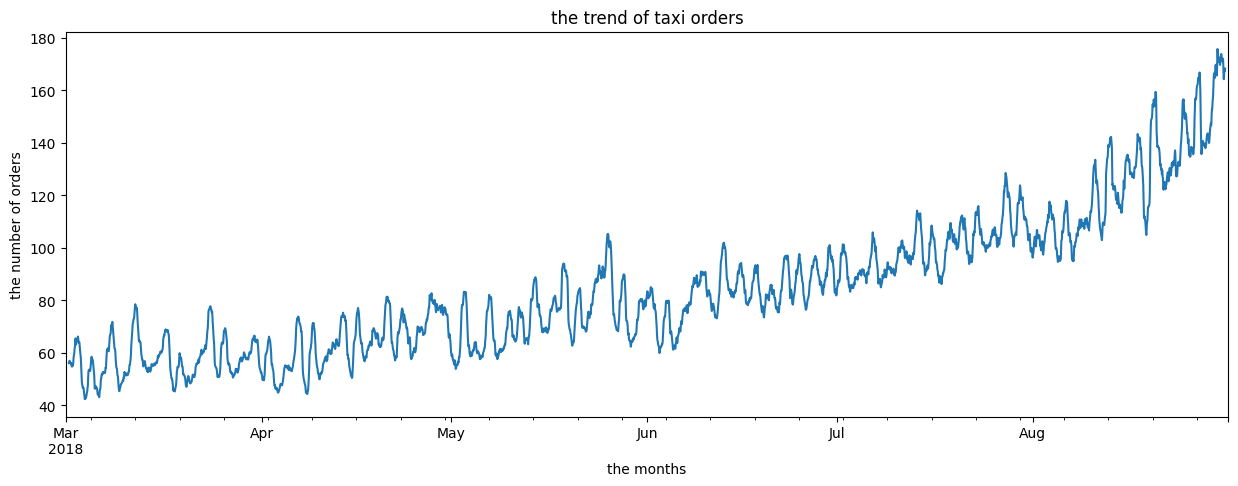

In [14]:
decomposed.trend.plot(title='the trend of taxi orders',  ylabel= 'the number of orders', xlabel= 'the months', figsize=(15,5));

The graphs show that the minimum number of orders is early in the morning, during the morning hours (6-11 o’clock) the number of orders increases, in the afternoon it decreases, a second rise by 17 o’clock, then a decline and a maximum rise at midnight. When assessing the dynamics by day of the week, we see maximum peaks on Saturday, a decrease on Sunday and a rise again on Monday.


In [12]:
data1 = df_taxi['2018-04-01':'2018-04-08'].resample('1H').sum()
data1['rolling_mean']=data1.shift().rolling(24).mean()

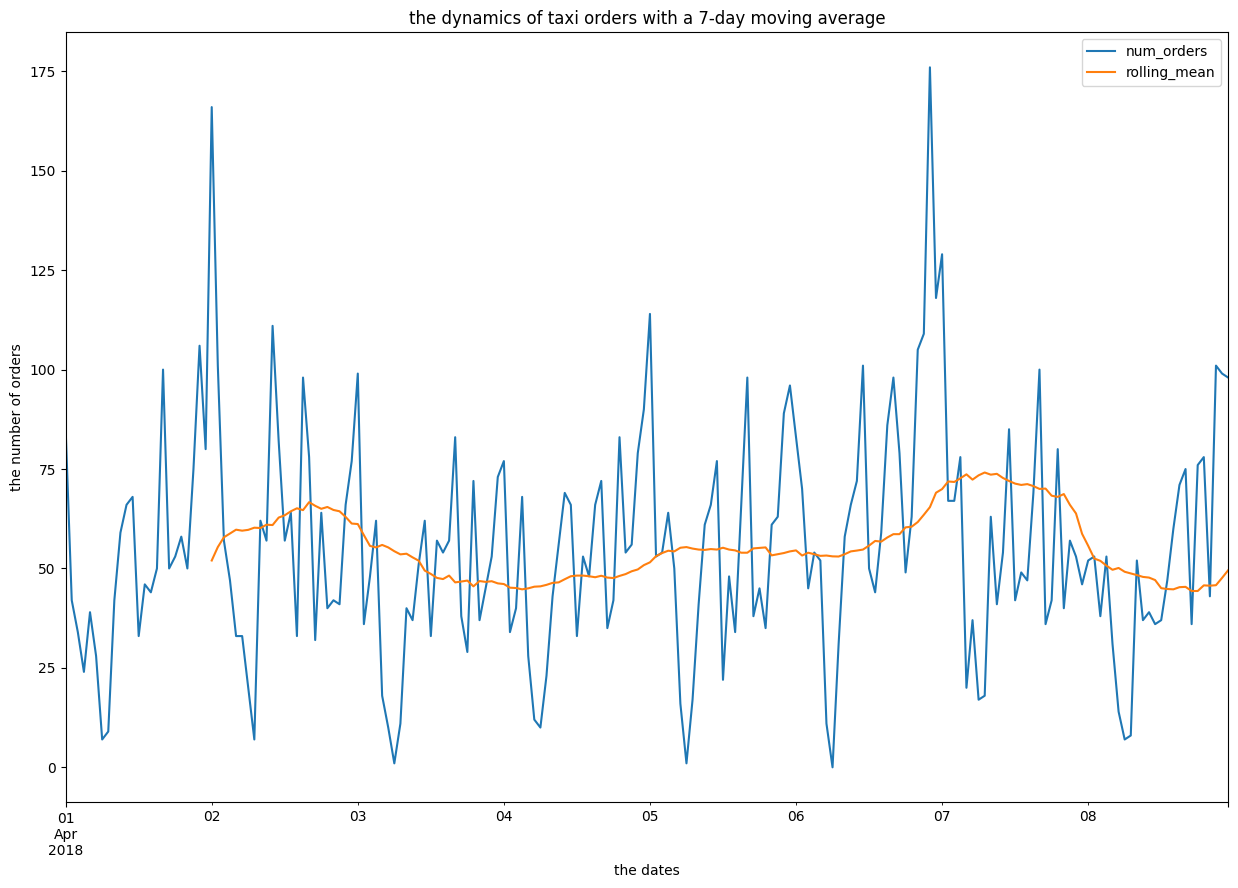

In [13]:
data1.plot(title='the dynamics of taxi orders with a 7-day moving average', ylabel= 'the number of orders',
           xlabel= 'the dates', figsize=(15,10));

As is known, in a stationary series the moving average should not have fluctuations around the baseline; in our case, the average number of orders is about 50, there are fluctuations from 30 to 75, therefore the series cannot be called strictly stationary.

Let's check the time series for stationarity using the Dickey-Fuller test; to do this, we estimate the p_value to test the null hypothesis that the time series is nonstationary; the alternative hypothesis says that the series is stationary. Taking into account the instability of the moving average in our series, it is necessary to take a more stringent p_value criterion for evaluation (0.01). If its value is less than 0.01, the time series is stationary; if not, we cannot accept the hypothesis about the stationarity of the time series

In [11]:
adf_test=adfuller(df_taxi['num_orders'])

print('p_value = ' +str(adf_test[1]))

p_value = 0.028940051402613316


The Dickey-Fuller criterion does not allow us to reject the null hypothesis that the series is nonstationary. Thus, graphical analysis and statistical tests indicate the nonstationarity of the series.

Having assessed the time series of taxi orders for a day, a week and 6 months, we conclude that:

1. during the day, the maximum number of orders is at midnight, the minimum at 6 am, moderate rises at 11 and 17 o'clock;

2. during the week there are fluctuations in the number of orders with peaks on Saturdays and Mondays;

3. during the period March-September 2018, there was an increase in the number of orders, most pronounced at the end of the period.

Let's evaluate the autocorrelation of our dataset

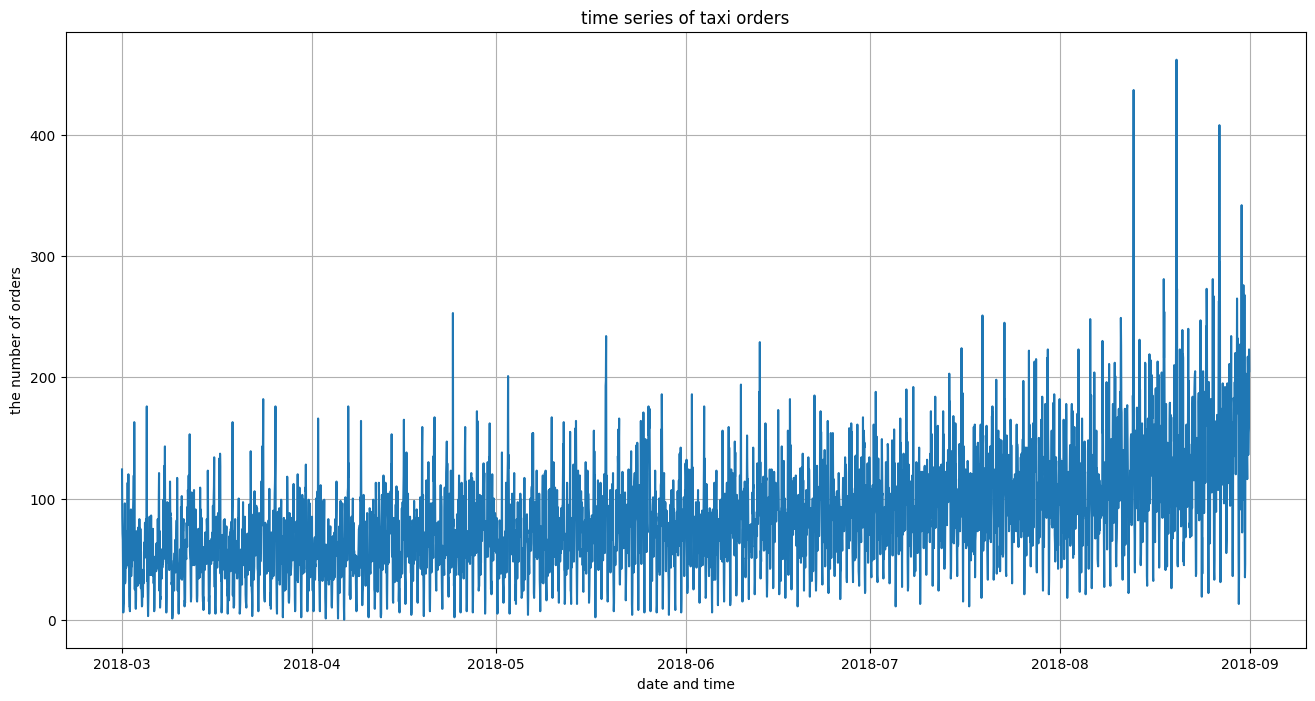

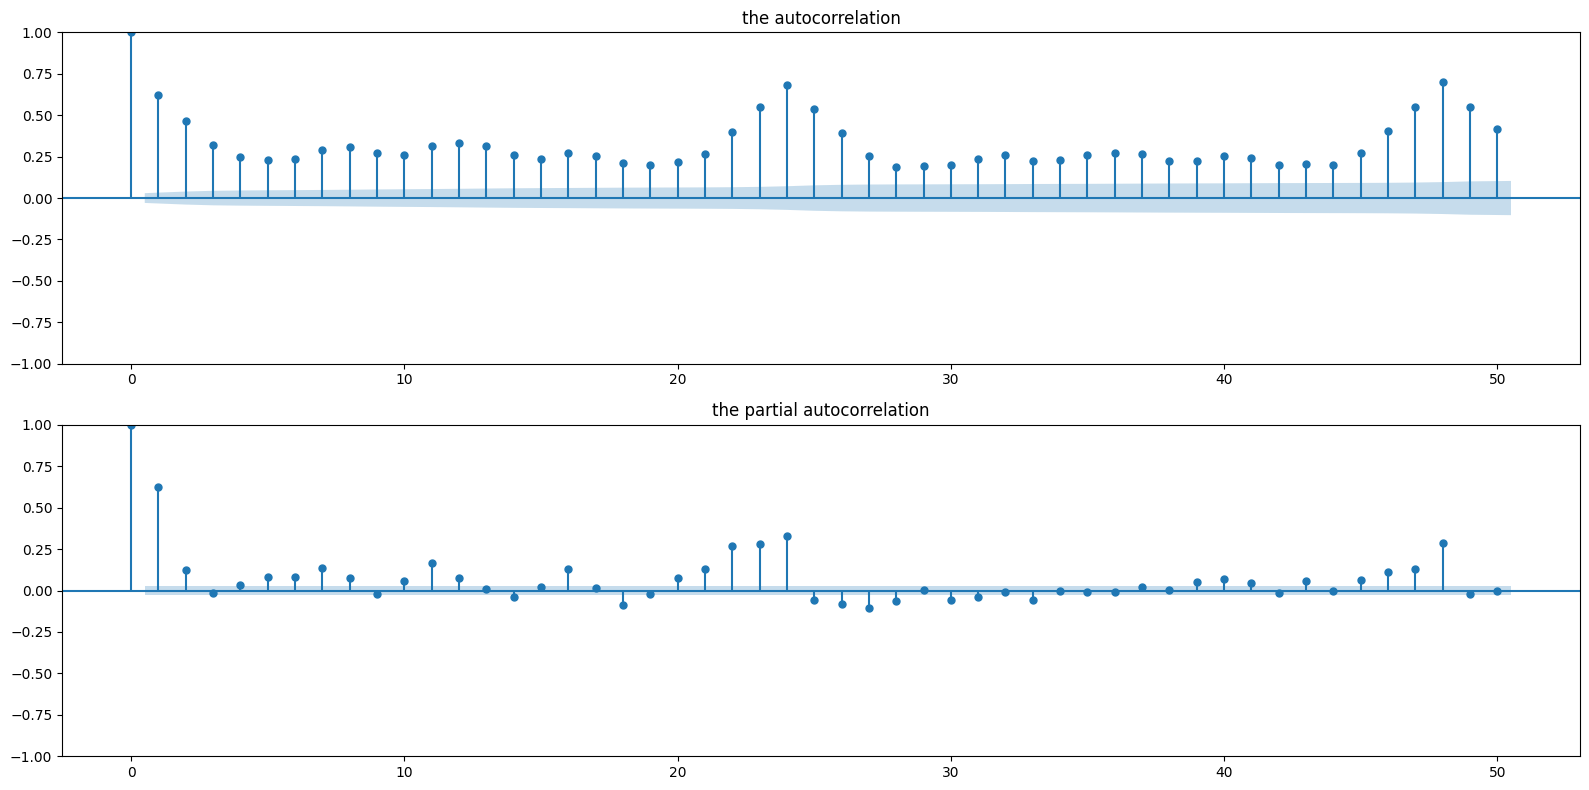

In [16]:
plt.figure(figsize=(16, 8))
plt.plot(df_taxi.index, df_taxi['num_orders'])
plt.title('time series of taxi orders')
plt.xlabel('date and time')
plt.ylabel('the number of orders')
plt.grid(True)
plt.show()

plt.figure(figsize=(16, 8))
plt.subplot(211)
plot_acf(df_taxi['num_orders'], lags=50, ax=plt.gca())
plt.title('the autocorrelation')

plt.subplot(212)
plot_pacf(df_taxi['num_orders'], lags=50, ax=plt.gca())
plt.title('the partial autocorrelation')

plt.tight_layout()
plt.show()

The highest autocorrelation of attribute values ​​with the hours closest to peak hours and with a lag of 24 hours, i.e. daily allowance

# Model training

*Exponential smoothing.*

 Unlike the moving average, in the exponential smoothing or exponential moving average model, we take all previous values ​​and give each of the observations a certain weight and (exponentially) reduce this weight as we go deeper into the past, with the future predicted value depending on both current true and current predicted values. The importance of these values ​​is determined by the alpha parameter, set in the range from 0 to 1 (which
 more, the more weight a true observation has).

In [17]:
alpha=0.7

exp_smoothing=[df_taxi['num_orders'][0]]

for i in range(1, len(df_taxi['num_orders'])):
  exp_smoothing.append(alpha*df_taxi['num_orders'][i]+(1-alpha)*exp_smoothing[i-1])


In [18]:

len(df_taxi), len(exp_smoothing)

(4416, 4416)

In [19]:
df_taxi['Exp_smoothing'] = exp_smoothing

In [20]:
last_hour = df_taxi.iloc[[-1]].index

In [21]:
last_hour = last_hour + timedelta(hours = 1)
last_hour

DatetimeIndex(['2018-09-01'], dtype='datetime64[ns]', name='datetime', freq='H')

In [22]:
df_taxi = pd.concat([df_taxi, pd.DataFrame(index = last_hour)])

In [23]:
df_taxi['Exp_smoothing'] = df_taxi['Exp_smoothing'].shift(1)

In [24]:
df_taxi.isna().sum()

num_orders       1
Exp_smoothing    1
dtype: int64

In [25]:
df_taxi.dropna()

,num_orders,Exp_smoothing
datetime,,
2018-03-01 01:00:00,85.0,124.000000
2018-03-01 02:00:00,71.0,96.700000
2018-03-01 03:00:00,66.0,78.710000
2018-03-01 04:00:00,43.0,69.813000
2018-03-01 05:00:00,6.0,51.043900
...,...,...
2018-08-31 19:00:00,136.0,206.217254
2018-08-31 20:00:00,154.0,157.065176
2018-08-31 21:00:00,159.0,154.919553


Using the exponential smoothing method, we obtained a forecast for 1 hour ahead.
We will also train a DecisionTree and a GradientBoosting. First, add new features to the dataset and divide the dataset into a training and test set. We will select the hyperparameters of the models using cross-validation.

In [26]:
df_taxi1=df_taxi.copy()
df_taxi1
df_taxi1 = df_taxi1.dropna()

In [27]:
df_taxi1['dayofweek'] = df_taxi1.index.dayofweek

In [28]:
df_taxi1['day'] = df_taxi1.index.day

In [29]:
df_taxi1['hour'] = df_taxi1.index.hour

In [30]:
for lag in range(1,25):
        df_taxi1['lag_{}'.format(lag)] = df_taxi1['num_orders'].shift(lag)

In [31]:
df_taxi1['rolling_mean'] = df_taxi1['num_orders'].shift().rolling(24).mean()

In [32]:
train, test = train_test_split(df_taxi1, shuffle=False, test_size=0.1)
train = train.dropna()

X_train=train.drop('num_orders', axis=1)
y_train=train['num_orders']
X_test=test.drop('num_orders', axis=1)
y_test=test['num_orders']

In [33]:
model = DecisionTreeRegressor(random_state=42)

In [34]:
tscv=TimeSeriesSplit(n_splits=5)

In [35]:
param_grid = {
    'min_samples_leaf': range(7,14),
    'max_depth': range(7,14)
}

In [36]:
grid = GridSearchCV(
    model,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1

)
grid.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(7, 14),
                         'min_samples_leaf': range(7, 14)},
             scoring='neg_root_mean_squared_error')

In [37]:
print('The best model and its parameters:\n\n', grid.best_estimator_)
print ('RMSE-level of the best model DecisionTreeRegressor on cross-validation:', grid.best_score_*-1)

The best model and its parameters:

 DecisionTreeRegressor(max_depth=7, min_samples_leaf=10, random_state=42)
RMSE-level of the best model DecisionTreeRegressor on cross-validation: 29.25552551656515


In [38]:
pred=grid.best_estimator_.predict(X_test)
print("RMSE-level of DecisionTreeRegressor on the test set:", mean_squared_error(y_test, pred, squared=False))

RMSE-level of DecisionTreeRegressor on the test set: 53.10476899173492


In [43]:
model_1=LGBMRegressor(random_state=42, verbose=-1)

In [44]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': range(3, 6)
}

In [45]:
grid_1 = GridSearchCV(
    model_1,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1

)
grid_1.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LGBMRegressor(random_state=42, verbose=-1), n_jobs=-1,
             param_grid={'max_depth': range(3, 6),
                         'n_estimators': [50, 100, 150]},
             scoring='neg_root_mean_squared_error')

In [47]:
print('The best model and its parameters:\n\n', grid_1.best_estimator_)
print ('RMSE-level of the best model LGBMRegressor on cross-validation:', grid_1.best_score_*-1)

The best model and its parameters:

 LGBMRegressor(max_depth=5, random_state=42, verbose=-1)
RMSE-level of the best model LGBMRegressor on cross-validation: 24.71656930503222


In [48]:
X_test.dropna()
y_test.dropna()

datetime
2018-08-13 14:00:00    102.0
2018-08-13 15:00:00    175.0
2018-08-13 16:00:00    144.0
2018-08-13 17:00:00    152.0
2018-08-13 18:00:00    104.0
                       ...  
2018-08-31 19:00:00    136.0
2018-08-31 20:00:00    154.0
2018-08-31 21:00:00    159.0
2018-08-31 22:00:00    223.0
2018-08-31 23:00:00    205.0
Freq: H, Name: num_orders, Length: 442, dtype: float64

In [50]:
pred_1=grid_1.best_estimator_.predict(X_test)
print("RMSE-level of LGBMRegressor on the test set:", mean_squared_error(y_test, pred_1, squared=False))

RMSE-level of LGBMRegressor on the test set: 40.87961099109875


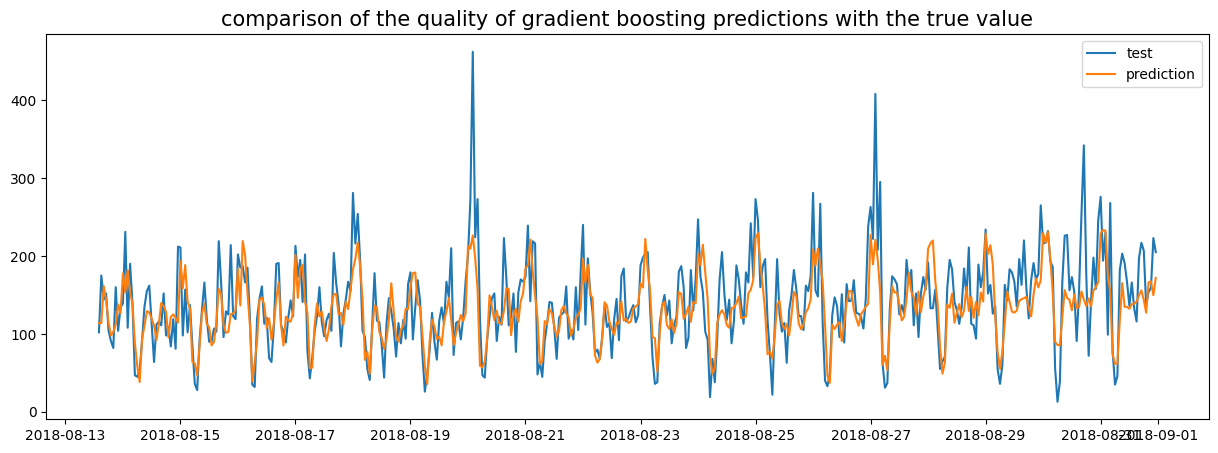

In [51]:
plt.figure(figsize=(15, 5))
plt.title("comparison of the quality of gradient boosting predictions with the true value", fontsize=15)

plt.plot(y_test, label="test")
plt.plot(y_test.index, pred_1, label="prediction")
plt.legend()
plt.show()

The decision tree gives a slightly worse metric on cross-validation compared to gradient boosting with hyperparameters max_depth=4, n_estimators=150, so the best model is gradient boosting, respectively, this model was used to obtain predictions on the test sample; the result of gradient boosting on the test sample corresponds a given criterion, accordingly, this model will be offered to the customer as a model for forecasting orders. A graphical assessment of the agreement between predictions and real values ​​showed quite sufficient agreement; in a 1-hour forecast, the model can give a fairly good forecast in terms of accuracy.

## Common conclusion:
Libraries and dataset were imported, data was resampled for 1 hour. A time series analysis and an assessment for stationarity were carried out, and seasonality and trend graphs were constructed.

The Dickey-Fuller test doesn't allowed us to reject the null hypothesis about the non-stationarity of the series, what is supported by the trend and seasonality graphs, we have to consider our series to be non-stationary

Having assessed the time series of taxi orders for a day, a week and 6 months, the following conclusions were drawn:

1. during the day, the maximum number of orders is at midnight, the minimum at 6 am, moderate rises at 11 and 17 o'clock;

2. during the week there are fluctuations in the number of orders with peaks on Saturdays and Mondays;

3. during the period March-September 2018, there was an increase in the number of orders, most pronounced at the end of the period.

Predictions of the number of orders for each hour were obtained using the exponential average method and added to the main dataset;

The next step was to add a number of new features to the dataset; after dividing the dataset into train/test, empty values ​​were removed from the training set. 2 models were trained - DecisionTreeRegressor and LightGBM, hyperparameters were selected on cross-validation for both models.

Model training results:

 The best model and her parameters: LGBMRegressor(max_depth=4, n_estimators=150),

RMSE-level of best model on cross-validation: 24.804610360100765,

RMSE-level of best model on test sample: 40.80576166792768